In [1]:
import os
import flopy as f
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
ws = "work/ex11"
name = "modflow_project"
exe_name = "exe/mf6.exe"

In [3]:
# create simulation
sim = f.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name=exe_name)

In [4]:
# Temporal discretization
nper = 1
perlen = 8640000
nstp = 1
steady = [True]
tdis = f.mf6.ModflowTdis(sim, time_units="seconds", nper = 1, perioddata=[(8640000, 1, 1)], steady=steady)

In [5]:
ims = f.mf6.ModflowIms(sim)

In [6]:
# create model object
gwf = f.mf6.ModflowGwf(sim, modelname=name)

In [7]:
# Spatial Discretization
nlay, nrow, ncol = 1, 25, 20
delr=delc=50
top=120
botm=75
ibound = np.ones((nlay, nrow, ncol), dtype=np.int64)
ibound[:,:23,:4]=0
ibound[:,1:23,19]=0

Dis = f.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                            top=top, botm=botm,delr=delr, delc=delc, idomain=ibound)

In [9]:
# Defining initial conditions

start=120
ic = f.mf6.ModflowGwfic(gwf, strt=start)

In [10]:
# Node Properties Definition
kh=kva=10e-5
laytyp=[1]

npf = f.mf6.ModflowGwfnpf(gwf,save_specific_discharge=True, icelltype=laytyp, k=kh, k33=kva)

In [11]:
# Recharge package
rch = f.mf6.ModflowGwfrcha(gwf, recharge=2e-8)

In [12]:
# Defining Constant Head
# chd_rec= {0:[[0,0,5,100.0],[0,0,6,100.0],[0,0,7,100.0],[0,0,8,100.0],[0,0,9,100.0],[0,0,10,100.0],[0,nrow-1,5,95]]}
# # np.array([chd_rec], dtype=[("i","<i8"), ("j","<i8"),("k","<i8"),("start","<f8")])

chdd = []
layer = 0
for i in range(5,20):
    chdd.append(((layer, 0, i), 100))
    if i != range(5,20):
        chdd.append(((layer, nrow-1, i), 95))
# ,[0,0,10,100.0],[0,0,11,100.0], [0,0,12,100.0],[0,0,13,100.0],[0,0,14,100.0],[0,0,15,100.0], [0,nrow-1,0,95],[0,nrow-1,1,95],[0,nrow-1,2,95],[0,nrow-1,3,95],[0,nrow-1,4,95]

chd=f.mf6.ModflowGwfchd(gwf, stress_period_data=chdd)
# ipr=1
# ra = chd.stress_period_data.get_data(key=ipr)
# ra
# chd_rec


In [40]:
iper = 0
ra = chd.stress_period_data.get_data(key=iper)
ra

rec.array([((0, 0, 5), 100.), ((0, 24, 5),  95.), ((0, 0, 6), 100.),
           ((0, 24, 6),  95.), ((0, 0, 7), 100.), ((0, 24, 7),  95.),
           ((0, 0, 8), 100.), ((0, 24, 8),  95.), ((0, 0, 9), 100.),
           ((0, 24, 9),  95.), ((0, 0, 10), 100.), ((0, 24, 10),  95.),
           ((0, 0, 11), 100.), ((0, 24, 11),  95.), ((0, 0, 12), 100.),
           ((0, 24, 12),  95.), ((0, 0, 13), 100.), ((0, 24, 13),  95.),
           ((0, 0, 14), 100.), ((0, 24, 14),  95.), ((0, 0, 15), 100.),
           ((0, 24, 15),  95.), ((0, 0, 16), 100.), ((0, 24, 16),  95.),
           ((0, 0, 17), 100.), ((0, 24, 17),  95.), ((0, 0, 18), 100.),
           ((0, 24, 18),  95.), ((0, 0, 19), 100.), ((0, 24, 19),  95.)],
          dtype=[('cellid', 'O'), ('head', '<f8')])

In [14]:
headfile=f"{name}.hds"
head_filerecord=[headfile]
budgetfile=f"{name}.cbb"
budget_filerecord=[budgetfile]
saverecord=[("HEAD","ALL"),("BUDGET","ALL")]
printrecord=[("HEAD","LAST")]

oc=f.mf6.ModflowGwfoc(gwf,saverecord=saverecord,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,printrecord=printrecord)

In [15]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model modflow_project...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 30 based on size of stress_period_data
    writing package oc...


In [16]:
success, buff = sim.run_simulation()
# assert success, "MODFLOW 6 did not terminate normally"

FloPy is using the following executable to run the model: exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Dec 09 2022 18:18:37 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall b

In [17]:
fpth = "work/ex11/modflow_project.hds"
hds = f.utils.HeadFile(fpth)

In [16]:
# kstpkper : tuple of ints
#             A tuple containing the time step and stress period (kstp, kper).
#             These are zero-based kstp and kper values

In [18]:
kst=hds.get_kstpkper

h = hds.get_data(kstpkper=(0,0))


In [41]:
# plt.subplot(1,1,1, aspect="equal")
# fig = plt.gcf()
# fig.set_figheight(10)
# fig.set_figwidth(10)
# head = h
# levels= np.arange(0,120,0.5)
# c=plt.contour(head[0,:,:], levels=levels, colors="red")
# plt.clabel(c,fmt="%2.1f")

In [21]:
ibd = np.ones((nlay, nrow, ncol), dtype=np.int64)
for k, i, j in ra["cellid"]:
    ibd[k, i, j] = -1

<a list of 90 text.Text objects>

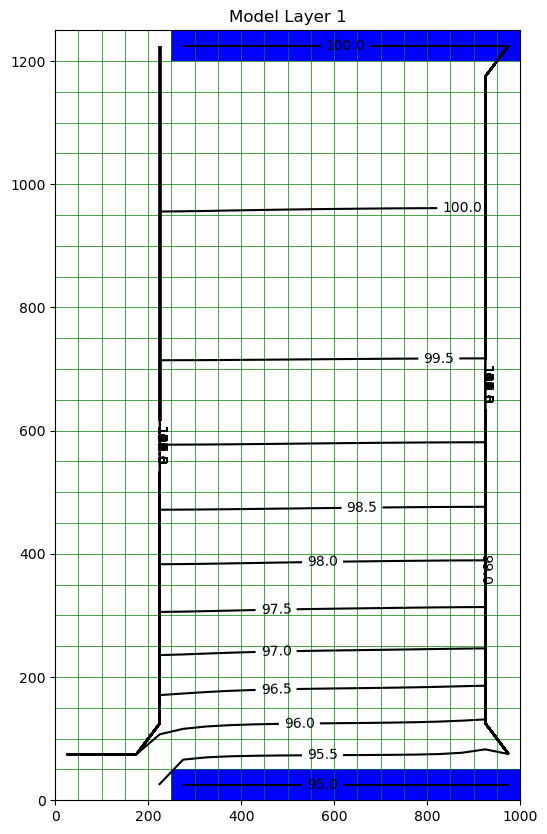

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(6, 10))
ax = axes
ax.set_title("Model Layer 1")
modelmap = f.plot.PlotMapView(model=gwf, ax=ax)
quadmesh = modelmap.plot_ibound(ibound=(ibd))
linecollection = modelmap.plot_grid(lw=0.5, color="green")
contours = modelmap.contour_array(
    h[0], levels=np.arange(90, 120, 0.5), colors="black"
)
ax.clabel(contours, fmt="%2.1f")

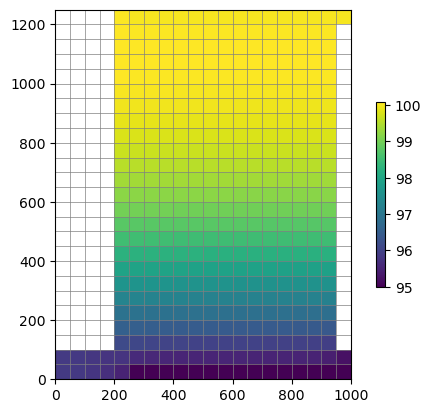

In [22]:
m = f.plot.PlotMapView(gwf)
# w=m.plot_bc("CHD")
mm=m.plot_array(h, masked_values=[1e30])
m.plot_grid(lw=0.5, color="0.5")
cb = plt.colorbar(mm, shrink=0.5)

In [21]:
# fname = os.path.join(str(modelpth), "freyberg.cbc")
# cbb = f.utils.CellBudgetFile(fname)
# frf = cbb.get_data(text="FLOW RIGHT FACE")[0]
# fff = cbb.get_data(text="FLOW FRONT FACE")[0]
# qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
#     (frf, fff, None), ml, head=head
# )

# fname = os.path.join(str("work/ex11/"), "._modflow_project.cbb")
# cbb= f.utils.CellBudgetFile(fname)
# # y = cbb.get_data(text="DATA SPDIS")[0]

# frf = cbb.get_data(text="FLOW RIGHT FACE")[0][0]
# fff = cbb.get_data(text="FLOW FRONT FACE")[0][0]
# qx,qy,qz = f.utils.postprocessing.get_specific_discharge((frf,fff, None), gwf, head = h)